In [44]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../output/ts_dw.csv', header=[0, 1, 2], index_col=[0])
df

40                                    80           \
                        dw2km              dw3km              dw2km            
                     sodar_ws dw2km_ws  sodar_ws dw3km_ws  sodar_ws dw2km_ws   
t                                                                              
2016-09-23 12:00:00  8.540000     2.97  8.540000     3.01  8.940000     3.50   
2016-09-23 12:30:00  7.033333     2.41  7.033333     3.53  8.410000     3.87   
2016-09-23 13:00:00  5.510000     3.55  5.510000     4.91  6.483333     5.02   
2016-09-23 13:30:00  6.123333     4.99  6.123333     4.96  6.750000     6.72   
2016-09-23 14:00:00  5.363333     4.66  5.363333     4.70  6.296667     5.91   
...                       ...      ...       ...      ...       ...      ...   
2016-09-25 10:00:00  1.696667     0.78  1.696667     0.78  2.406667     0.66   
2016-09-25 10:30:00  1.176667     0.37  1.176667     0.40  1.770000     0.42   
2016-09-25 11:00:00  1.680000     0.71  1.680000     0.63  1.930000     0.17   
2016-09-25 11:30:00  2.120000     0.57  2.120000     0.84  1.910000     0.55   
2016-09-25 12:00:00  1.420000     0.77  1.420000     0.96  1.583333     0.70   

                                             120                              
                        dw3km              dw2km              dw3km           
                     sodar_ws dw3km_ws  sodar_ws dw2km_ws  sodar_ws dw3km_ws  
t                                                                             
2016-09-23 12:00:00  8.940000     3.50  9.770000     4.12  9.770000     4.12  
2016-09-23 12:30:00  8.410000     4.91  9.323333     5.00  9.323333     5.84  
2016-09-23 13:00:00  6.483333     6.04  6.923333     6.22  6.923333     6.85  
2016-09-23 13:30:00  6.750000     6.07  7.166667     7.85  7.166667     6.94  
2016-09-23 14:00:00  6.296667     5.58  6.730000     7.03  6.730000     6.45  
...                       ...      ...       ...      ...       ...      ...  
2016-09-25 10:00:00  2.406667     0.85  2.443333     1.08  2.443333     1.18  
2016-09-25 10:30:00  1.770000     0.40  2.085000     0.87  2.085000     0.80  
2016-09-25 11:00:00  1.930000     0.45  1.150000     0.60  1.150000     0.72  
2016-09-25 11:30:00  1.910000     0.90  1.800000     0.96  1.800000     1.15  
2016-09-25 12:00:00  1.583333     0.97  1.136667     1.07  1.136667     1.21  

[97 rows x 12 columns]

In [6]:
df['40']

dw2km              dw3km         
                     sodar_ws dw2km_ws  sodar_ws dw3km_ws
t                                                        
2016-09-23 12:00:00  8.540000     2.97  8.540000     3.01
2016-09-23 12:30:00  7.033333     2.41  7.033333     3.53
2016-09-23 13:00:00  5.510000     3.55  5.510000     4.91
2016-09-23 13:30:00  6.123333     4.99  6.123333     4.96
2016-09-23 14:00:00  5.363333     4.66  5.363333     4.70
...                       ...      ...       ...      ...
2016-09-25 10:00:00  1.696667     0.78  1.696667     0.78
2016-09-25 10:30:00  1.176667     0.37  1.176667     0.40
2016-09-25 11:00:00  1.680000     0.71  1.680000     0.63
2016-09-25 11:30:00  2.120000     0.57  2.120000     0.84
2016-09-25 12:00:00  1.420000     0.77  1.420000     0.96

[97 rows x 4 columns]

In [19]:
df.xs('40', axis=1)

dw2km              dw3km         
                     sodar_ws dw2km_ws  sodar_ws dw3km_ws
t                                                        
2016-09-23 12:00:00  8.540000     2.97  8.540000     3.01
2016-09-23 12:30:00  7.033333     2.41  7.033333     3.53
2016-09-23 13:00:00  5.510000     3.55  5.510000     4.91
2016-09-23 13:30:00  6.123333     4.99  6.123333     4.96
2016-09-23 14:00:00  5.363333     4.66  5.363333     4.70
...                       ...      ...       ...      ...
2016-09-25 10:00:00  1.696667     0.78  1.696667     0.78
2016-09-25 10:30:00  1.176667     0.37  1.176667     0.40
2016-09-25 11:00:00  1.680000     0.71  1.680000     0.63
2016-09-25 11:30:00  2.120000     0.57  2.120000     0.84
2016-09-25 12:00:00  1.420000     0.77  1.420000     0.96

[97 rows x 4 columns]

In [24]:
df.columns.levels[2]

Index(['dw2km_ws', 'dw3km_ws', 'sodar_ws'], dtype='object')

In [58]:
import matplotlib.dates as mdates

In [81]:
df.index = pd.to_datetime(df.index)
df2.index = pd.to_datetime(df2.index)

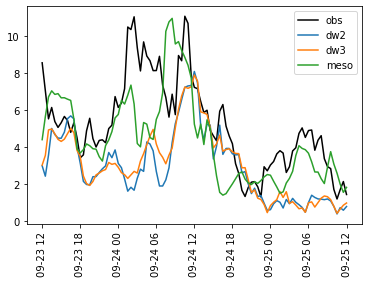

In [82]:
fig, ax = plt.subplots()
ax.plot(df.index, df['40']['dw2km']['sodar_ws'], label='obs', c='k')
ax.plot(df.index, df['40']['dw2km']['dw2km_ws'], label='dw2')
ax.plot(df.index, df['40']['dw3km']['dw3km_ws'], label='dw3')
ax.plot(df2.index, df2['40']['meso']['meso_ws'], label='meso')
plt.xticks(rotation=90)
plt.legend()
plt.show()

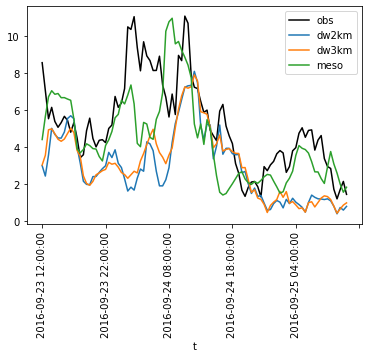

In [73]:
fig, ax = plt.subplots()
df['40']['dw2km']['sodar_ws'].plot(label='obs', c='k', ax=ax)
df['40']['dw2km']['dw2km_ws'].plot(label='dw2km', ax=ax)
df['40']['dw3km']['dw3km_ws'].plot(label='dw3km', ax=ax)
df2['40']['meso']['meso_ws'].plot(label='meso', ax=ax)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%h'))
# ax.set_xticks(pd.to_datetime(df.index))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=90)
plt.legend()
plt.show()

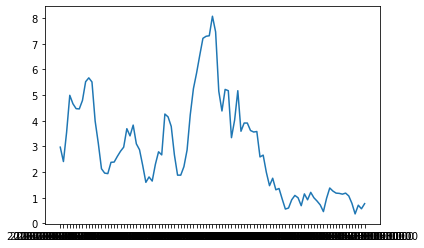

In [47]:
plt.plot(df.index, df['40']['dw2km']['dw2km_ws'])

In [48]:
df.index

Index(['2016-09-23 12:00:00', '2016-09-23 12:30:00', '2016-09-23 13:00:00',
       '2016-09-23 13:30:00', '2016-09-23 14:00:00', '2016-09-23 14:30:00',
       '2016-09-23 15:00:00', '2016-09-23 15:30:00', '2016-09-23 16:00:00',
       '2016-09-23 16:30:00', '2016-09-23 17:00:00', '2016-09-23 17:30:00',
       '2016-09-23 18:00:00', '2016-09-23 18:30:00', '2016-09-23 19:00:00',
       '2016-09-23 19:30:00', '2016-09-23 20:00:00', '2016-09-23 20:30:00',
       '2016-09-23 21:00:00', '2016-09-23 21:30:00', '2016-09-23 22:00:00',
       '2016-09-23 22:30:00', '2016-09-23 23:00:00', '2016-09-23 23:30:00',
       '2016-09-24 00:00:00', '2016-09-24 00:30:00', '2016-09-24 01:00:00',
       '2016-09-24 01:30:00', '2016-09-24 02:00:00', '2016-09-24 02:30:00',
       '2016-09-24 03:00:00', '2016-09-24 03:30:00', '2016-09-24 04:00:00',
       '2016-09-24 04:30:00', '2016-09-24 05:00:00', '2016-09-24 05:30:00',
       '2016-09-24 06:00:00', '2016-09-24 06:30:00', '2016-09-24 07:00:00',
       '2016

In [25]:
df2 = pd.read_csv('../output/ts_meso.csv', header=[0, 1, 2], index_col=[0])
df2

40                 80                120          
                         meso               meso               meso          
                     sodar_ws  meso_ws  sodar_ws  meso_ws  sodar_ws   meso_ws
t                                                                            
2016-09-23 12:00:00  8.540000  4.38475  8.940000  5.99613  9.770000  7.463710
2016-09-23 12:30:00  7.033333  5.62862  8.410000  6.54774  9.323333  7.527240
2016-09-23 13:00:00  5.510000  6.69482  6.483333  7.57294  6.923333  8.407080
2016-09-23 13:30:00  6.123333  7.02331  6.750000  7.64358  7.166667  8.050320
2016-09-23 14:00:00  5.363333  6.83114  6.296667  7.23761  6.730000  7.323200
...                       ...      ...       ...      ...       ...       ...
2016-09-25 10:00:00  1.696667  3.06640  2.406667  1.90579  2.443333  1.492080
2016-09-25 10:30:00  1.176667  2.57236  1.770000  1.87107  2.085000  1.525850
2016-09-25 11:00:00  1.680000  1.97721  1.930000  1.67323  1.150000  1.531680
2016-09-25 11:30:00  2.120000  1.53617  1.910000  1.15805  1.800000  0.943818
2016-09-25 12:00:00  1.420000  1.80532  1.583333  1.15768  1.136667  0.760471

[97 rows x 6 columns]

In [27]:
df2.columns.levels[2]

Index(['meso_ws', 'sodar_ws'], dtype='object')